# Лаб 3. Нейросетевые алгоритмы

Ниже представлены три разных модели рекомендательных систем, которые используют нейронные сети.

Задание:
1. Ознакомится с представленными моделями
2. Для каждой модели подобрать гиперпараметры, чтобы улучшить метрику RMSE.
3. Для DeepFM, помимо гиперпараметров, добавьте хотя бы одно дополнительное поле (можно использовать данные из папки ml-latest-small или напарсить ещё больше данных с помощью links.csv)
4. Соревнование до 1 декабря на бонусные баллы на лучшую метрику RMSE с использованием любой модели (RANDOM_SEED при тестировании будет изменён):
    1. место: 10 баллов
    2. место: 5 баллов
    3. место: 2 балла

In [1]:
from platform import python_version
print(python_version())

3.8.10


Ставим библиотеки

In [2]:
# об установке pytorch https://pytorch.org/get-started/locally/
#%pip install --quiet -U recommenders tensorflow torch tf-slim

Импорты

In [3]:
import pandas as pd
import numpy as np
import os
import cornac

# Для разделения выборки на тестовую и обучающую
from recommenders.datasets.python_splitters import python_random_split

# Пакеты для NCF
from recommenders.models.ncf.ncf_singlenode import NCF
from recommenders.models.ncf.dataset import Dataset as NCFDataset

# Пакеты для BiVAE
from recommenders.models.cornac.cornac_utils import predict
from recommenders.evaluation.python_evaluation import rmse

# Пакеты для DeepFM
from recommenders.models.deeprec.deeprec_utils import prepare_hparams, cal_metric
from recommenders.models.deeprec.models.xDeepFM import XDeepFMModel
from recommenders.models.deeprec.io.iterator import FFMTextIterator


FM model is only supported on Linux.
Windows executable can be found at http://www.libfm.org.


Загрузка датасета

In [4]:
RANDOM_SEED = 42  # глобальный сид рандома

ratings = pd.read_csv('./ml-latest-small/ratings.csv', delimiter=',')
movies = pd.read_csv('./ml-latest-small/movies.csv', delimiter=',')

# Приводим рейтинги, которые будем предсказывать, к диапазону от 0 до 1
ratings["rating"] = ratings["rating"] / 5

# Делим выборку на тестовую и обучающую
train_ratings, test_ratings = python_random_split(ratings, 0.75, seed=RANDOM_SEED)

# Некоторые алгоритмы (этот алгоритм это NFC) не работают, если в тестовой выборке есть пользователи
# или айтемы, которых не было в тренировочной, так что исключаем их из тестовой выборки
# (это проблема холодного старта, один из недостатков алгоритмов в том чисел матричной факторизации)
test_ratings = test_ratings[test_ratings["userId"].isin(train_ratings["userId"].unique())]
test_ratings = test_ratings[test_ratings["movieId"].isin(train_ratings["movieId"].unique())]

# Neural Collaborative Filtering

![структура NCF](images/NCF.svg)
(иллюстрация взята с [microsoft recommenders](https://github.com/recommenders-team/recommenders/blob/main/examples/02_model_collaborative_filtering/ncf_deep_dive.ipynb))

Идея NCF в использовании разложения пользователей и айтемов на вектора признаков, как это делается в матричных разложениях, только вместо линейной комбинации этих векторов использовать нейронную сеть. Модель NCF состоит из двух независимых частей -- GMF части и MLP части (подробнее в оригинальной [статье](https://arxiv.org/abs/1708.05031)), каждый из которых имеет свой собственных вектор признаков.

In [5]:
# Загружаем тренировочный и тестовый датасет обратно в csv, потому что в таком виде их принимает библиотека
if not os.path.isdir(os.path.join('.', r'tmp')):
    os.mkdir(os.path.join('.', r'tmp'))

train_csv_file = os.path.join('.', r'tmp', r'train.csv')
test_csv_file = os.path.join('.', r'tmp', r'test.csv')
train_ratings.sort_values(by='userId').to_csv(train_csv_file, index=False)
test_ratings.sort_values(by='userId').to_csv(test_csv_file, index=False)


In [6]:
# Для этой модели нужно создать специальный объект датасета, который является матрицей юзеров-айтемов
data = NCFDataset(train_file=train_csv_file, test_file=test_csv_file, col_user='userId', col_item='movieId', seed=RANDOM_SEED)

INFO:recommenders.models.ncf.dataset:Indexing .\tmp\train.csv ...
INFO:recommenders.models.ncf.dataset:Indexing .\tmp\test.csv ...
INFO:recommenders.models.ncf.dataset:Indexing .\tmp\test_full.csv ...


In [7]:
# Параметры модели
EPOCHS = 30
BATCH_SIZE = 200

model = NCF(
    n_users=data.n_users, # юзеры
    n_items=data.n_items, # айтемы
    model_type="NeuMF",   # модель NeuMF комбинирует MLP и GMF
    n_factors=2,          # размер вектора признаков
    layer_sizes=[8,6,4,2,1], # структура слоёв нейросети
    n_epochs=EPOCHS,      # количество эпох
    batch_size=BATCH_SIZE,# размер батча
    learning_rate=0.001,  # скорость обучения
    verbose=10,           # уровень логирования (логировать каждую 10-ю эпоху)
    seed=RANDOM_SEED      # сид рандома
)

c:\users\pavel\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1697: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [8]:
model.fit(data)

INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [6.33s]: train_loss = 0.330598 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [4.35s]: train_loss = 0.298476 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [4.49s]: train_loss = 0.290989 


In [9]:
# Считаем предсказания и метрику RMSE
pred = [model.predict(int(i[1]['userId']), int(i[1]['movieId'])) for i in test_ratings.iterrows()]
cal_metric(test_ratings['rating'].to_numpy(), pred, ['rmse'])

{'rmse': 0.35482389998420344}

# Bilateral Variational Autoencoder (BiVAE)

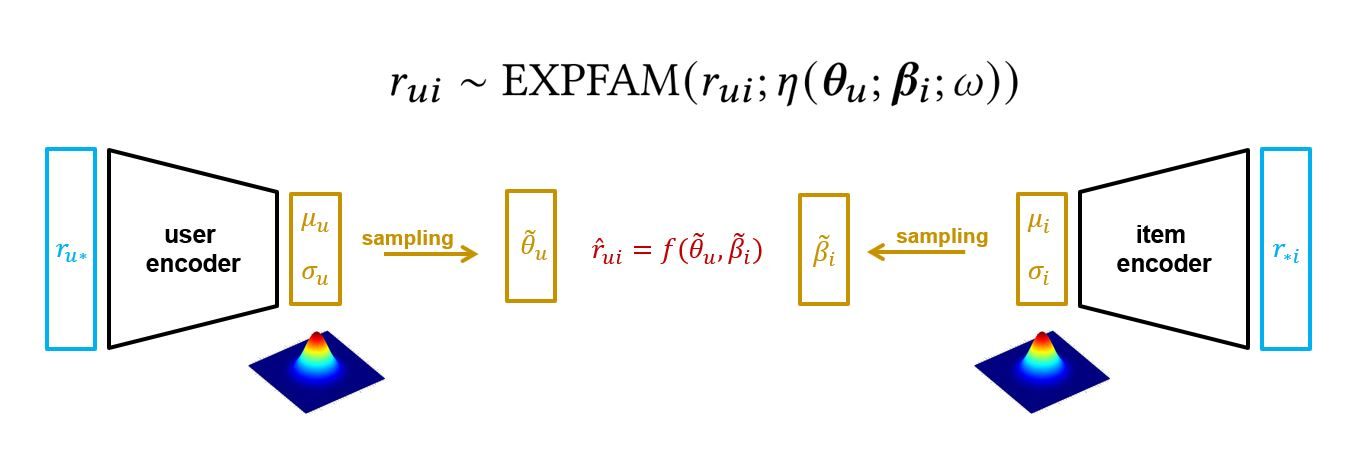

(иллюстрация взята с [microsoft recommenders](https://github.com/recommenders-team/recommenders/blob/main/examples/02_model_collaborative_filtering/cornac_bivae_deep_dive.ipynb))

Модель BiVAE использует нейросеть для формирования векторов признаков пользователей и айтемов, для этого используется Variational Autoencoder $-$ автоэнкодер, который генерирует не сам вектор, а распределение в пространстве признаков. С этим распределением из пространства признаков случайно выбираются значения для обучения.


In [10]:
# Тут тоже есть отдельный объект для представления матрицы матрицу юзеров-айтемов
train_set = cornac.data.Dataset.from_uir(train_ratings.to_numpy(), seed=RANDOM_SEED)

print('Number of users: {}'.format(train_set.num_users))
print('Number of items: {}'.format(train_set.num_items))

Number of users: 610
Number of items: 8787


In [11]:
'''
f=0
dict ={}
for siz in range (80,101,10):
    for eph in range (50, 71,10):
        for kk in range (45,56,5):
            for structure in range (80, 101,10):
                EPOCHS = eph
                BATCH_SIZE = siz
                
                bivae = cornac.models.BiVAECF(
                    k=kk,                  # размер пространства вектора признаков
                    encoder_structure=[structure], # структура промежуточных нейронных слоёв
                    act_fn="tanh",         # функция активации
                    likelihood="pois",     # функция распределения (у нас распределение Пуассона)
                    n_epochs=EPOCHS,       # количество эпох
                    batch_size=BATCH_SIZE, # размер батча
                    learning_rate=0.001,   # скорость обучения
                    seed=RANDOM_SEED,      # сид рандома
                    use_gpu=False,         # считаем на CPU
                    verbose=False           # логирование
                )
                bivae.fit(train_set)
                # Предсказания для тестовой выборки
                predictions = predict(bivae, test_ratings, usercol='userId', itemcol='movieId', predcol="predict")
                # Считаем ошибку
                rme=rmse(test_ratings, predictions, "userId", "movieId", "rating", "predict")
                f+=1
                dict[rme]=[eph, siz,kk,structure, f]
                #if f==1:
                print(rme,'   ', siz, eph,kk,structure, f)
                #print(f)
import collections
od = collections.OrderedDict(sorted(dict.items()))
od
'''

'\nf=0\ndict ={}\nfor siz in range (80,101,10):\n    for eph in range (50, 71,10):\n        for kk in range (45,56,5):\n            for structure in range (80, 101,10):\n                EPOCHS = eph\n                BATCH_SIZE = siz\n                \n                bivae = cornac.models.BiVAECF(\n                    k=kk,                  # размер пространства вектора признаков\n                    encoder_structure=[structure], # структура промежуточных нейронных слоёв\n                    act_fn="tanh",         # функция активации\n                    likelihood="pois",     # функция распределения (у нас распределение Пуассона)\n                    n_epochs=EPOCHS,       # количество эпох\n                    batch_size=BATCH_SIZE, # размер батча\n                    learning_rate=0.001,   # скорость обучения\n                    seed=RANDOM_SEED,      # сид рандома\n                    use_gpu=False,         # считаем на CPU\n                    verbose=False           # логирован

In [12]:
'''
print(rme,'   ',eph, siz,kk,structure, f)
0.4686814585641009 [80, 100, 30, 100, 2]


(0.4645603438386115, [60, 80, 50, 100, 15]),
(0.4712575661252534, [50, 100, 55, 100, 63]),
(0.4719316881792669, [50, 80, 50, 90, 5]),
'''

"\nprint(rme,'   ',eph, siz,kk,structure, f)\n0.4686814585641009 [80, 100, 30, 100, 2]\n\n\n(0.4645603438386115, [60, 80, 50, 100, 15]),\n(0.4712575661252534, [50, 100, 55, 100, 63]),\n(0.4719316881792669, [50, 80, 50, 90, 5]),\n"

In [13]:
# Создаём саму модель

            
EPOCHS = 60
BATCH_SIZE = 80

bivae = cornac.models.BiVAECF(
    k=50,                  # размер пространства вектора признаков
    encoder_structure=[100], # структура промежуточных нейронных слоёв
    act_fn="tanh",         # функция активации
    likelihood="pois",     # функция распределения (у нас распределение Пуассона)
    n_epochs=EPOCHS,       # количество эпох
    batch_size=BATCH_SIZE, # размер батча
    learning_rate=0.001,   # скорость обучения
    seed=RANDOM_SEED,      # сид рандома
    use_gpu=False,         # считаем на CPU
    verbose=True           # логирование
)


In [14]:
# Обучаем модель
bivae.fit(train_set)

  0%|          | 0/60 [00:00<?, ?it/s]

In [15]:
# Предсказания для тестовой выборки
predictions = predict(bivae, test_ratings, usercol='userId', itemcol='movieId', predcol="predict")
# Считаем ошибку
rmse(test_ratings, predictions, "userId", "movieId", "rating", "predict")

0.4645603438386115

## Deep Factorization Machine (DeepFM)

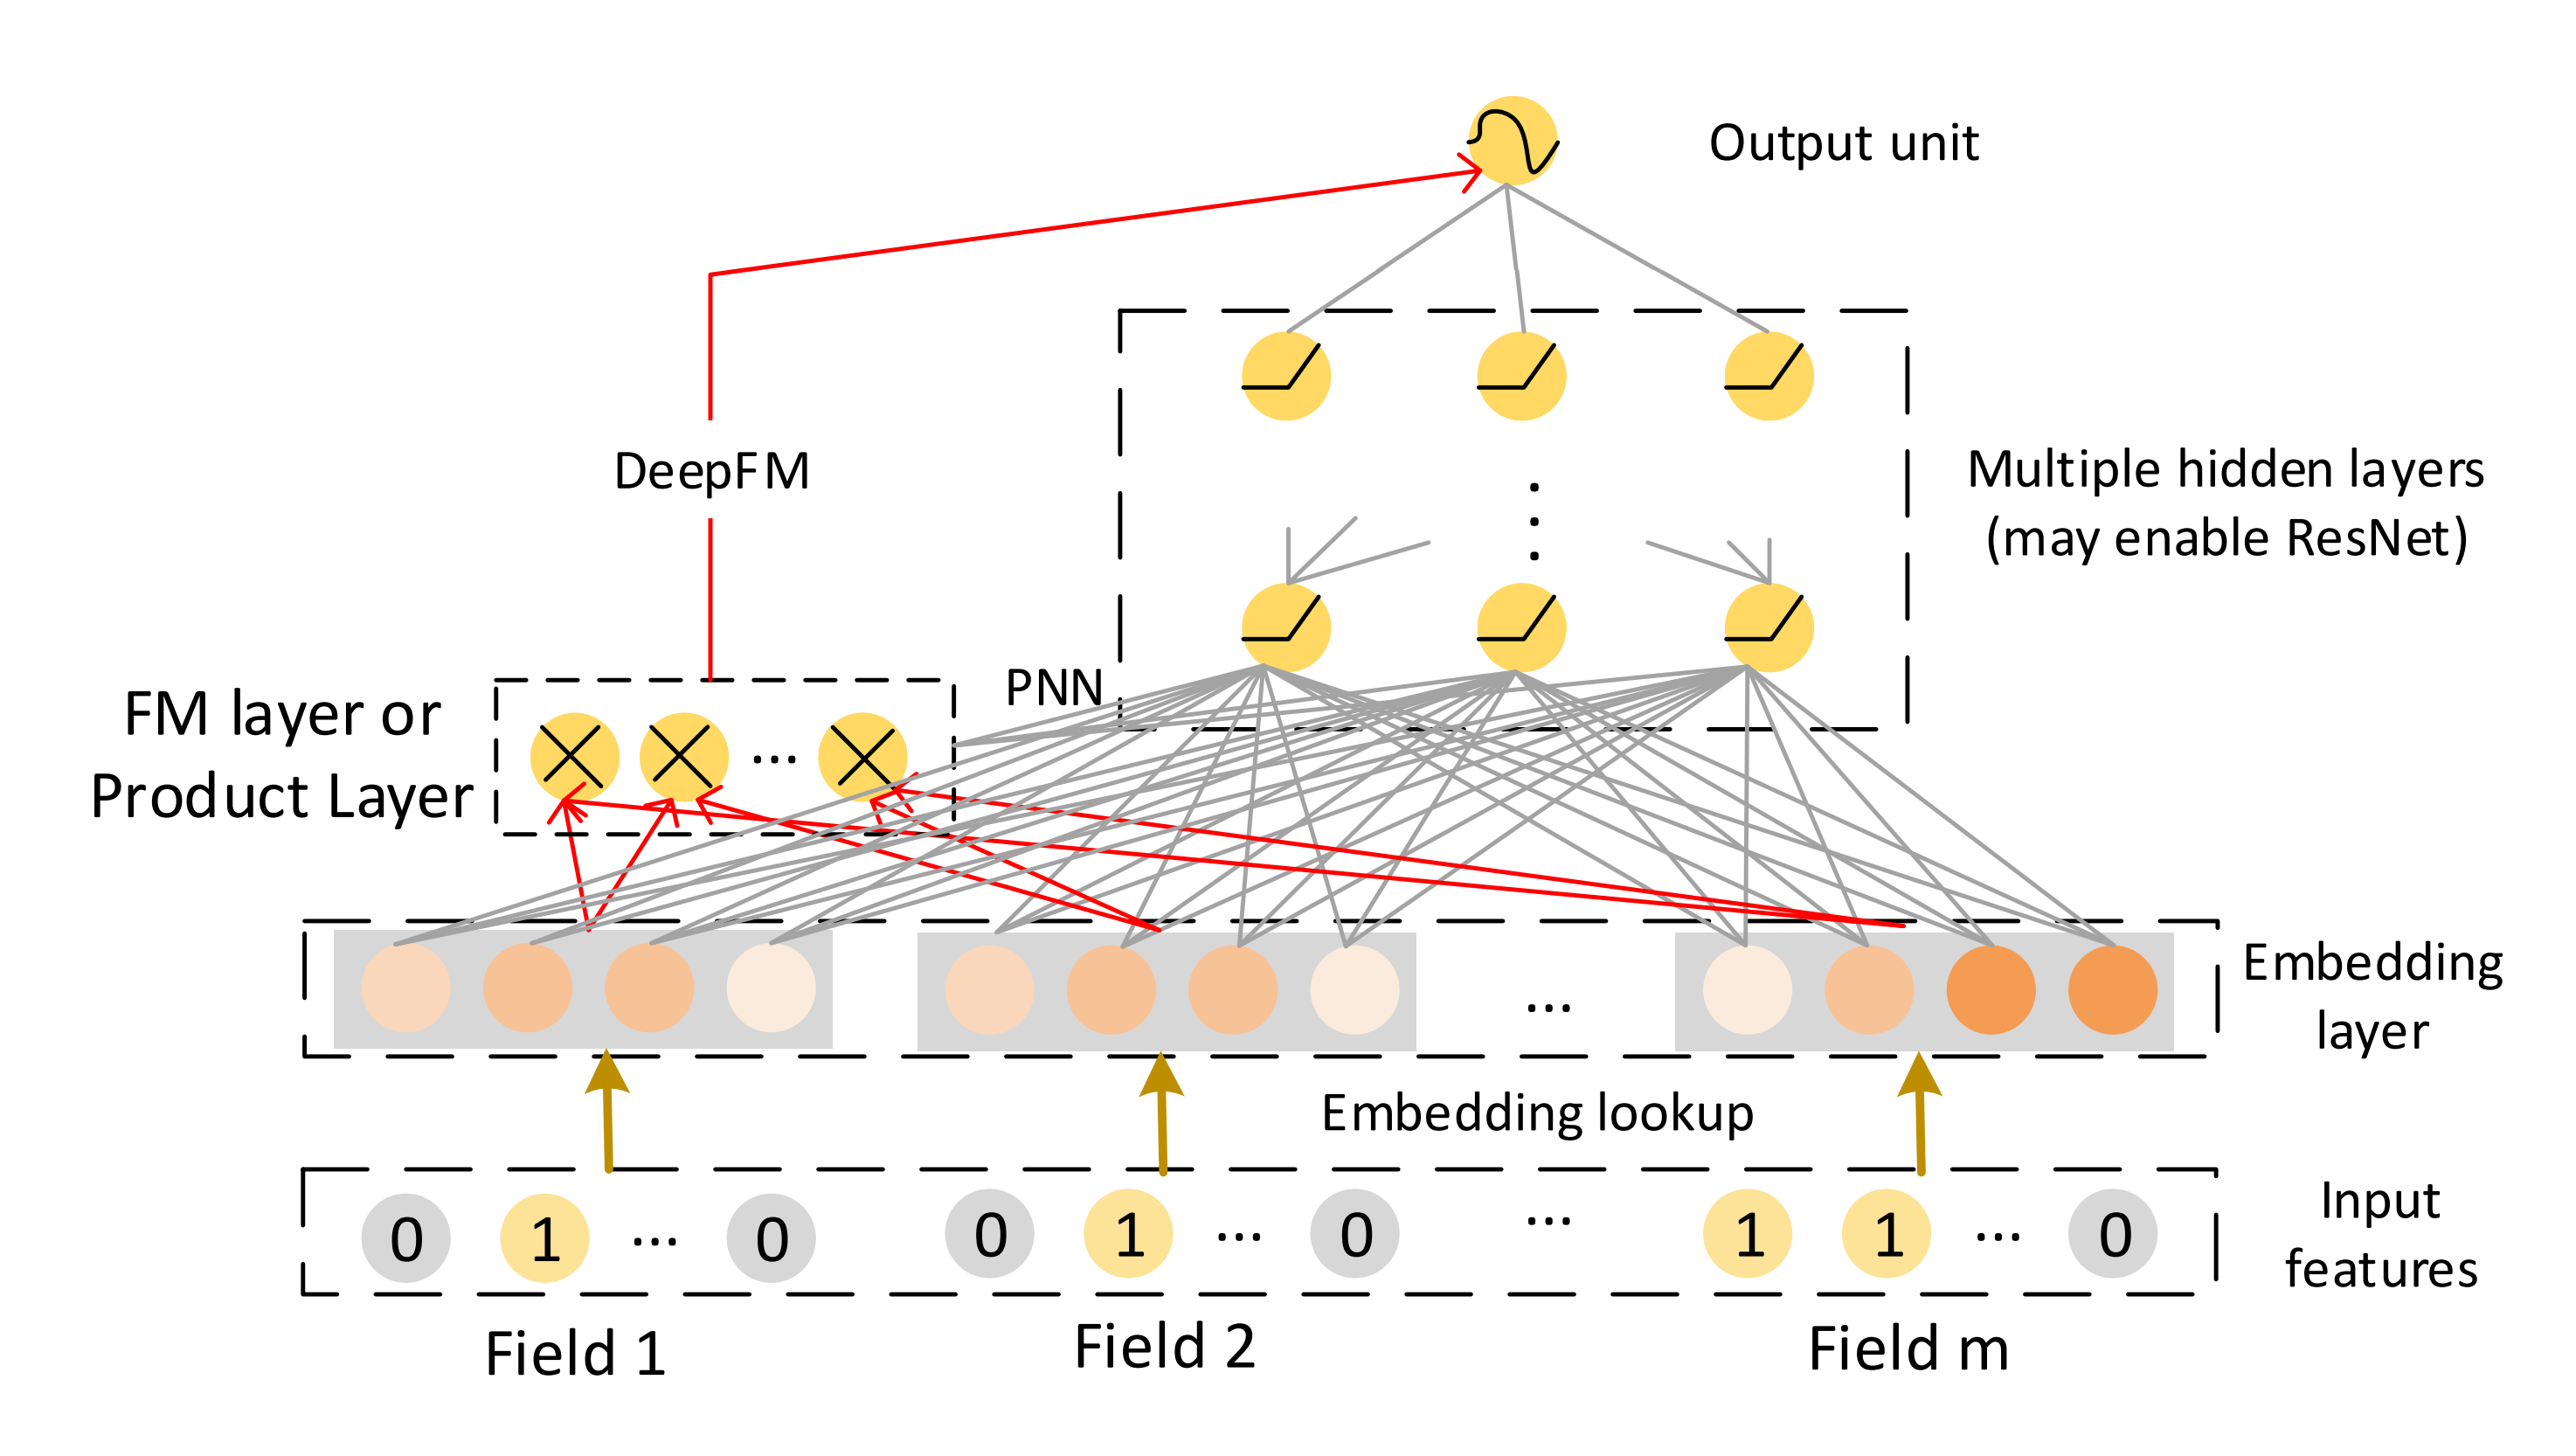
(Иллюстрация взята из статьи [xDeepFM](https://arxiv.org/pdf/1803.05170.pdf))

Это аналог обычной Factorization Machine, где вместе со слоем попарных произведений векторов признаков используется слой глубокой нейронной сети. Исходные признаки в DeepFM кодируются one-hot encoding и делятся на области, такие как пользователи, фильмы, жанр фильма, возраст пользователя и тд.

В нашем случае используется модель [xDeepFM](https://arxiv.org/pdf/1803.05170.pdf), которая отличается от классической [DeepFM](https://arxiv.org/abs/1703.04247) наличием ещё одного дополнительного CIN компонента, для примера мы его выключили.

In [16]:
# Имена файлов конфига и датасетов
yaml_file = os.path.join('.', r'lab3_file', r'xDeepFM.yaml') # в конфиге находятся некоторые полезные настройки модели
train_file = os.path.join('.', r'tmp', r'train')
test_file = os.path.join('.', r'tmp', r'test')

In [17]:
arr=[]
for m in movies["genres"]:
    arr+=m.split("|")
#list(dict.fromkeys(arr))
counter = {}

for elem in arr:
    counter[elem] = counter.get(elem, 0) + 1

doubles = {element: count for element, count in counter.items() if count > 1}

{k: v for k, v in sorted(doubles.items(), key=lambda item: item[1],reverse=True)}

{'Drama': 4361,
 'Comedy': 3756,
 'Thriller': 1894,
 'Action': 1828,
 'Romance': 1596,
 'Adventure': 1263,
 'Crime': 1199,
 'Sci-Fi': 980,
 'Horror': 978,
 'Fantasy': 779,
 'Children': 664,
 'Animation': 611,
 'Mystery': 573,
 'Documentary': 440,
 'War': 382,
 'Musical': 334,
 'Western': 167,
 'IMAX': 158,
 'Film-Noir': 87,
 '(no genres listed)': 34}

In [18]:
f=0
for m in movies["genres"]:
    movies["genres"][f]=m.split("|")
    f+=1

C:\Users\pavel\AppData\Local\Temp\ipykernel_1968\508502750.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies["genres"][f]=m.split("|")


In [19]:
list(dict.fromkeys(arr))

['Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'Mystery',
 'Sci-Fi',
 'War',
 'Musical',
 'Documentary',
 'IMAX',
 'Western',
 'Film-Noir',
 '(no genres listed)']

In [20]:
'''
dict={
    'Adventure':[],
 'Animation':[],
 'Children':[],
 'Comedy':[],
 'Fantasy':[],
 'Romance':[],
 'Drama':[],
 'Action':[],
 'Crime':[],
 'Thriller':[],
 'Horror':[],
 'Mystery':[],
 'Sci-Fi':[],
 'War':[],
 'Musical':[],
 'Documentary':[],
 'IMAX':[],
 'Western':[],
 'Film-Noir':[],
 '(no genres listed)':[]
}
for t in range(100836 ):
    a=  movies.loc[movies['movieId'] == ratings['movieId'][t]]['genres'].tolist()
    for i in a[0]:
        dict[i].append(ratings['rating'][t])
from statistics import mean
new_d = {name: mean(sub_dict) for name, sub_dict in dict.items()}
{k: v for k, v in sorted(new_d.items(), key=lambda item: item[1],reverse=True)}
'''

"\ndict={\n    'Adventure':[],\n 'Animation':[],\n 'Children':[],\n 'Comedy':[],\n 'Fantasy':[],\n 'Romance':[],\n 'Drama':[],\n 'Action':[],\n 'Crime':[],\n 'Thriller':[],\n 'Horror':[],\n 'Mystery':[],\n 'Sci-Fi':[],\n 'War':[],\n 'Musical':[],\n 'Documentary':[],\n 'IMAX':[],\n 'Western':[],\n 'Film-Noir':[],\n '(no genres listed)':[]\n}\nfor t in range(100836 ):\n    a=  movies.loc[movies['movieId'] == ratings['movieId'][t]]['genres'].tolist()\n    for i in a[0]:\n        dict[i].append(ratings['rating'][t])\nfrom statistics import mean\nnew_d = {name: mean(sub_dict) for name, sub_dict in dict.items()}\n{k: v for k, v in sorted(new_d.items(), key=lambda item: item[1],reverse=True)}\n"

In [24]:
movies['Film-Noir']= np.nan
movies['Horror']= np.nan
for t in range(len(movies) ):
    if 'Film-Noir' in movies["genres"][t]:movies['Film-Noir'][t]=1
    else:movies['Film-Noir'][t]=0
    if 'Horror' in movies["genres"][t] :movies['Horror'][t]=1
    else:movies['Horror'][t]=0

C:\Users\pavel\AppData\Local\Temp\ipykernel_1968\1043802271.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  else:movies['Film-Noir'][t]=int(0)
C:\Users\pavel\AppData\Local\Temp\ipykernel_1968\1043802271.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  else:movies['Horror'][t]=int(0)
C:\Users\pavel\AppData\Local\Temp\ipykernel_1968\1043802271.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if 'Horror' in movies["genres"][t] :

In [26]:
movies

,movieId,title,genres,Film-Noir,Horror
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",0.0,0.0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",0.0,0.0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0.0,0.0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",0.0,0.0
4,5,Father of the Bride Part II (1995),[Comedy],0.0,0.0
...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]",0.0,0.0
9738,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]",0.0,0.0
9739,193585,Flint (2017),[Drama],0.0,0.0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]",0.0,0.0


In [27]:
# Имена файлов конфига и датасетов
yaml_file = os.path.join('.', r'lab3_file', r'xDeepFM.yaml') # в конфиге находятся некоторые полезные настройки модели
train_file = os.path.join('.', r'tmp', r'train')
test_file = os.path.join('.', r'tmp', r'test')


In [28]:
movies_count = len(movies)
users_count = ratings["userId"].max()

In [82]:
# Функция подготовки данных для Factorization Machine
# Записываем данные в формате
# <оценка> <номер поля>:<номер признака>:<значение признака> <номер поля>:<номер признака>:<значение признака> ...
# значение признака при one-hot encoding обычно 1 (признаки, для которых значение не устанавливается, равны 0)
def prepare_fm_ratings(ratings_data, out_file):
    lines = []
    for i in ratings_data.iterrows():
        row = i[1]
        user = int(row["userId"])
        movieId = row["movieId"]
        movie = movies[movies["movieId"] == movieId].index[0] + 1 # это не очень оптимальная строчка, из-за неё так долго считаются датасеты
        rating = row['rating']
        genrNoir=int(movies[movies["movieId"] == movieId]["Film-Noir"].values[0])+ 1
        genrHor=int(movies[movies["movieId"] == movieId]["Horror"].values[0])+ 1
        #print (i,'newnewnewnew', row,'newnewnewnew', user,'newnewnewnew', movieId,'newnewnewnew', movie,'newnewnewnew', rating)
        # Пока что тут только два поля -- пользователь и фильм
        lines.append(f"{rating} 1:{user}:1 2:{users_count + movie}:1 3:{users_count + movies_count+genrNoir}:1 4:{users_count + movies_count+2+genrHor}:1")
    with open(out_file, 'w') as file:
        file.write('\n'.join(lines))


In [83]:
# Подготавливаем выборку
prepare_fm_ratings(train_ratings, train_file)
prepare_fm_ratings(test_ratings, test_file)

In [117]:
# Настраиваем гиперпараметры
EPOCHS = 10
BATCH_SIZE = 4096

hparams = prepare_hparams(
    # Ямл файл с базовыми настройками
    yaml_file,
    # Настраиваем размеры датасета
    FEATURE_COUNT=movies_count + users_count+4, # суммарное количество признаков
    FIELD_COUNT=4,                            # количество полей
    # Включаем разные части xDeepFM (тут настроено так чтобы оно было обычном DeepFM)
    use_Linear_part=True, # линейный нейрон
    use_FM_part=True,     # квадратичная часть классической FM
    use_CIN_part=False,   # CIN слой (нововведение в xDeepFM)
    use_DNN_part=True,    # DNN слой
    # коэффициенты регуляризации (можно использовать и L1)
    embed_l2=0.01,        # регуляризатор для слоя признаков
    cross_l2=0.01,        # регуляризатор для CIN слоя
    layer_l2=0.01,        # регуляризатор для DNN слоя

    learning_rate=0.002,  # скорость обучения
    epochs=EPOCHS,        # количество эпох
    # всякие размеры слоёв
    batch_size=BATCH_SIZE,
    cross_layer_sizes=[20, 10],
    init_value=0.1,
    layer_sizes=[20,20],
)

print(hparams)

HParams object with values {'use_entity': True, 'use_context': True, 'cross_activation': 'identity', 'user_dropout': False, 'dropout': [0.0, 0.0], 'attention_dropout': 0.0, 'load_saved_model': False, 'fast_CIN_d': 0, 'use_Linear_part': True, 'use_FM_part': True, 'use_CIN_part': False, 'use_DNN_part': True, 'init_method': 'tnormal', 'init_value': 0.5, 'embed_l2': 0.01, 'embed_l1': 0.0, 'layer_l2': 0.01, 'layer_l1': 0.0, 'cross_l2': 0.01, 'cross_l1': 0.0, 'reg_kg': 0.0, 'learning_rate': 0.002, 'lr_rs': 1, 'lr_kg': 0.5, 'kg_training_interval': 5, 'max_grad_norm': 2, 'is_clip_norm': 0, 'dtype': 32, 'optimizer': 'adam', 'epochs': 10, 'batch_size': 4096, 'enable_BN': False, 'show_step': 200000, 'save_model': False, 'save_epoch': 2, 'write_tfevents': False, 'train_num_ngs': 4, 'need_sample': True, 'embedding_dropout': 0.0, 'EARLY_STOP': 100, 'min_seq_length': 1, 'slots': 5, 'cell': 'SUM', 'FIELD_COUNT': 4, 'FEATURE_COUNT': 10356, 'data_format': 'ffm', 'load_model_name': 'you model path', 'met

In [118]:
model = XDeepFMModel(hparams, FFMTextIterator, seed=RANDOM_SEED)

Add linear part.
Add FM part.
Add DNN part.


In [119]:
# Проверяем метрики перед обучением
model.run_eval(test_file)

{'rmse': 0.37229022}

In [120]:
# Обучаем
model.fit(train_file, test_file)
# test датасет тут используется исключительно для печатания метрики

at epoch 1
train info: logloss loss:104.15438039679276
eval info: rmse:0.30643108
at epoch 1 , train time: 3.0 eval time: 0.7
at epoch 2
train info: logloss loss:90.1087811118678
eval info: rmse:0.2787472
at epoch 2 , train time: 2.6 eval time: 0.9
at epoch 3
train info: logloss loss:77.9369101273386
eval info: rmse:0.261916
at epoch 3 , train time: 2.7 eval time: 0.7
at epoch 4
train info: logloss loss:67.43544347662674
eval info: rmse:0.25059927
at epoch 4 , train time: 2.7 eval time: 0.9
at epoch 5
train info: logloss loss:58.369036624306126
eval info: rmse:0.24207437
at epoch 5 , train time: 2.7 eval time: 0.7
at epoch 6
train info: logloss loss:50.52799425627056
eval info: rmse:0.23579653
at epoch 6 , train time: 2.7 eval time: 0.9
at epoch 7
train info: logloss loss:43.737184624922904
eval info: rmse:0.23086792
at epoch 7 , train time: 2.6 eval time: 0.7
at epoch 8
train info: logloss loss:37.85075478804739
eval info: rmse:0.22671568
at epoch 8 , train time: 2.7 eval time: 1.0
at

In [121]:
# Проверяем метрики ещё раз
model.run_eval(test_file)

{'rmse': 0.22045408}